<a href="https://colab.research.google.com/github/muarvyn/SuttonBartoRLBook.exercise/blob/monte_carlo/Racetrack/Exercise 5.12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
%%bash
if [ ! -f "../SeqGen.py" -o ! -f "../MCM.py" -o ! -f "../RacetrackSetup.py" ]
then
  wget -O RacetrackSetup.py https://raw.githubusercontent.com/muarvyn/SuttonBartoRLBook.exercise/monte_carlo/RacetrackSetup.py
  wget -O SeqGen.py https://raw.githubusercontent.com/muarvyn/SuttonBartoRLBook.exercise/monte_carlo/SeqGen.py
  wget -O MCM.py https://raw.githubusercontent.com/muarvyn/SuttonBartoRLBook.exercise/monte_carlo/MCM.py  
fi

In [15]:
import os
is_rep = os.path.isfile('../SeqGen.py') and os.path.isfile('../MCM.py') and os.path.isfile('../RacetrackSetup.py')
is_dwld = os.path.isfile('./SeqGen.py') and os.path.isfile('./MCM.py') and os.path.isfile('./RacetrackSetup.py')
assert is_rep or is_dwld

if is_rep: 
    lib_path = '..'
else:
    lib_path = '.'    

import sys
sys.path.append(lib_path)
import SeqGen
import RacetrackSetup as rt
import MCM

In [6]:
def initLearning(track_shape):
    QShape = track_shape + (rt.MAX_VELOCITY+1, rt.MAX_VELOCITY+1, rt.ACTIONS_NUM)
    np.random.seed(113)
    Q = (np.random.random(QShape)-0.5)*0.001 - 300.0
    return Q

REWARD = -1

def setupEnvironment(rt_contour, start_line, finish_line, Q, episodes_to_generate = 1000):
    sequence = SeqGen.SequenceGeneratorPlus(
                SeqGen.EpsilonGreedyPolicy(Q, 0.1),
                lambda: rt.getStartPosition(start_line),
                lambda s,a: rt.getTransition(
                        rt_contour, s, a, finish_line, 
                        getStartPosition=lambda: rt.getStartPosition(start_line),
                        is_challenge=True)
                    + (REWARD,),
                episodes_max=episodes_to_generate
               )
    return sequence

class ImmutableGreedyPolicy:
    def __init__(self, Q):
        self.action = np.argmax(Q,axis=-1);

    def __call__(self, state):
        return self.action[state]

### For plotting

In [7]:
class startPosition:
    def __init__(self, low, high, step=1):
        self.x = low
        self.high = high
        self.step = step
    
    def __call__(self):
        x = self.x
        nx = self.x + self.step
        if nx < self.high:
            self.x = nx
        return (x, 0, 0, 0)
    
def getTraces(contour, start_line, finish_line, Q, from_position=None, to_position=None):
    if from_position == None: from_position = start_line[0]
    if to_position == None: to_position = start_line[2]
    test_gen = SeqGen.SequenceGeneratorPlus(
        ImmutableGreedyPolicy(Q), 
        startPosition(from_position, to_position),
        lambda s,a: rt.getTransition(contour, s, a, finish_line, 
                            getStartPosition=lambda: rt.getStartPosition(start_line),
                            is_challenge=False)
                        + (REWARD,),
        episodes_max = to_position-from_position,
        episode_maxlen = 40
        )

    traces = []
    episode = []
    for state, is_terminal, next_state, action, reward in test_gen:
        episode.append(state[:2])
        if is_terminal:
            episode.append(next_state[:2])
            traces.append(np.array(episode)+0.5)
            episode = []

    return traces

def plotTraces(contour, traces):
    f = plt.figure(num=None, figsize=(8,10), dpi=100, facecolor='w', edgecolor='k')
    plt.axes().set_aspect('equal')
    cont = np.array(contour)
    plt.plot(cont[:,0], cont[:,1], figure=f)
    cols = ['red','yellow','black','green','magenta','blue']
    wids = [4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0]
    lnst = ['-', '--', '-.', ':']

    for i, trace in enumerate(traces):
        plt.plot(trace[:,0], trace[:,1], figure=f, linewidth=1+12/(i+2),
                 color=cols[i%len(cols)], ls=lnst[i%len(lnst)])


### Setup Environment #2

In [4]:
Q = initLearning(rt.track_shape_2)
sequence = setupEnvironment(rt.contour_2, rt.start_line_2, rt.finish_line_2, Q,
                           episodes_to_generate = 10000)
C_float = np.zeros(dtype=np.float, shape=Q.shape)
C_int = np.zeros(shape=Q.shape, dtype=int)

### Run Off-policy MC Control learning

In [5]:
#t_policy = getGreedyPolicy(Q)
MCM.learnByEpisode(sequence, 
                   lambda e,i: MCM.OffPolicyMCControl(e, Q, C_float, 
                                sequence.get_action.getDistribution, 0.98))

 Episode #:   10000; length:      39
Episodes generated: 10000


### Plot the paths of greedy policy in Environment #2

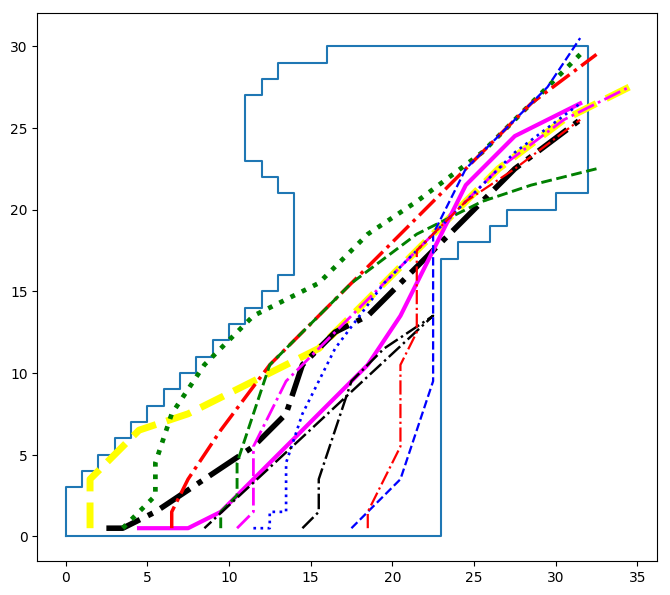

In [9]:
plotTraces(rt.contour_2, getTraces(rt.contour_2, rt.start_line_2, rt.finish_line_2, Q))
                                  #from_position=0, to_position=2))

### Run On-policy First Visit MC Control learning

In [ ]:
MCM.learnByEpisode(sequence, lambda e,i: MCM.OnPolicyFirstVisitMCControl(e, Q, C_int, 0.99))

### Run On-policy Every Visit MC Control learning

In [5]:
# To generate more steps in Environment #2
sequence = setupEnvironment(rt.contour_2, rt.start_line_2, rt.finish_line_2, Q)

In [7]:
MCM.learnByEpisode(sequence, lambda e,i: MCM.OnPolicyEveryVisitMCControl(e, Q, C_int, 0.99))

 Episode #:    1000; length:      35
Episodes generated: 1000


### Setup Environment #1

In [8]:
Q_1 = initLearning(rt.track_shape_1)
sequence_1 = setupEnvironment(rt.contour_1, rt.start_line_1, rt.finish_line_1, Q_1, 
                            episodes_to_generate=10000)
C_1_float = np.zeros(dtype=np.float, shape=Q_1.shape)
C_1_int = np.zeros(shape=Q_1.shape, dtype=int)

### Run On-policy Every Visit MC Control learning in Environment #1

In [9]:
#t_policy = getGreedyPolicy(Q)
MCM.learnByEpisode(sequence_1, 
                   #lambda e,i: MCM.OffPolicyMCControl(e, Q_1, C_1_float, 
                   #             sequence.get_action.getDistribution, 0.99))
                   lambda e,i: MCM.OnPolicyEveryVisitMCControl(e, Q_1, C_1_int, 0.98))


 Episode #:   10000; length:      17
Episodes generated: 10000


### Plot the paths of greedy policy in Environment #1

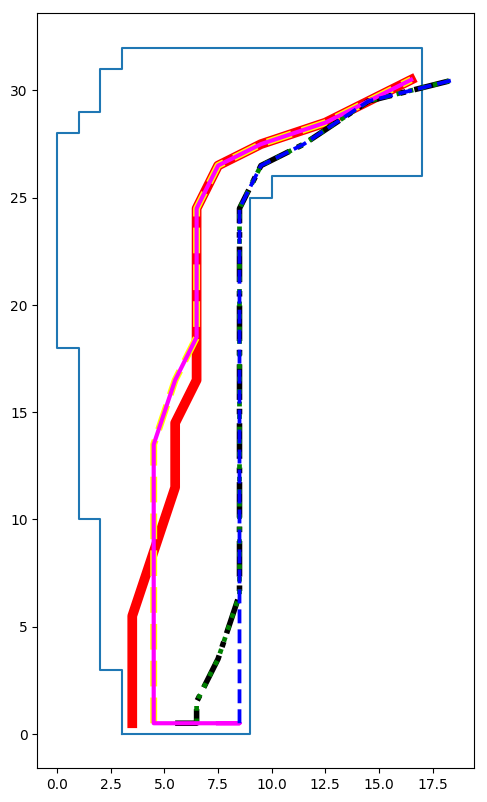

In [11]:
plotTraces(rt.contour_1, getTraces(rt.contour_1, rt.start_line_1, rt.finish_line_1, Q_1))
                                  #from_position = 6))


#### Some testing

In [ ]:
test_gen = SeqGen.SequenceGeneratorPlus(
    ImmutableGreedyPolicy(Q), 
    startPosition(start_line[0], start_line[2]),
    lambda s,a: rt.getTransition(rt.contour_1, s, a, rt.finish_line_1, 
                        getStartPosition=lambda: rt.getStartPosition(start_line))
                    + (REWARD,),
    episodes_max = start_line[2]-start_line[0],
    episode_maxlen = 40
    )
